## Import library

In [5]:
import os
import subprocess
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
n_qubit = params["circuit_info"]["n_qubit"]
each_n_shot = params["circuit_info"]["each_n_shot"]
state_name = params["circuit_info"]["state_name"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]
# RBM architecture parameter
n_visible_unit = params["architecture_info"]["n_visible_unit"]
n_hidden_unit = params["architecture_info"]["n_hidden_unit"] 
n_aux_unit = params["architecture_info"]["n_aux_unit"]
# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
seed = params["train_info"]["seed"]
# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]
# data path info
train_data_path = f"./data/{error_model}/error_prob_{100*error_rate}%/num_of_data_{each_n_shot}/"
ideal_state_path = f"./target_state/"

# settings
## warnings
warnings.simplefilter('ignore')

## seaborn layout
sns.set()
sns.set_style("white")

## seed
def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

## caluculate ideal state

In [6]:
# calculate ideal state
is_ideal_state_file = os.path.exists(ideal_state_path)
if is_ideal_state_file:
    print("ideal state data is exsisted !")
else:
    print("caluculate ideal state data ...")
    subprocess.run("python caluculate_ideal_state.py", shell=True)
    print("ideal state data is ready !")

ideal state data is exsisted !


## generate dataset

In [7]:
# generate train data
is_train_data_file = os.path.exists(train_data_path)
if is_train_data_file:
    print("train data is exsisted !")
else:
    print("generate directries & train data ...")
    os.makedirs(train_data_path, exist_ok = True)
    subprocess.run("python generate_dataset.py", shell=True)
    print("train data is ready !")

generate directries & train data ...


0it [00:00, ?it/s]
  1%|          | 10/1000 [00:00<00:10, 95.18it/s]

measurement pattern 0 : ('X', 'X')



100%|██████████| 1000/1000 [00:10<00:00, 91.45it/s]
1it [00:10, 10.94s/it]
  1%|          | 11/1000 [00:00<00:09, 108.68it/s]

measurement pattern 1 : ('X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 107.39it/s][A
2it [00:20,  9.98s/it]
  1%|          | 12/1000 [00:00<00:08, 114.15it/s]

measurement pattern 2 : ('X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 110.10it/s][A
3it [00:29,  9.57s/it]
  1%|          | 9/1000 [00:00<00:12, 78.98it/s]

measurement pattern 3 : ('Y', 'X')



100%|██████████| 1000/1000 [00:10<00:00, 99.30it/s]
4it [00:39,  9.77s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 4 : ('Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.78it/s][A
5it [00:48,  9.63s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 5 : ('Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 108.62it/s][A
6it [00:57,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 6 : ('Z', 'X')



100%|██████████| 1000/1000 [00:10<00:00, 96.05it/s]
7it [01:08,  9.79s/it]
  1%|          | 12/1000 [00:00<00:08, 112.26it/s]

measurement pattern 7 : ('Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.21it/s][A
8it [01:17,  9.67s/it]
  1%|          | 11/1000 [00:00<00:09, 106.52it/s]

measurement pattern 8 : ('Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 109.04it/s][A
9it [01:26,  9.67s/it]


train data is ready !


## load dataset

In [93]:
meas_pattern_path = train_data_path + "/measurement_pattern.txt"
meas_label_path = train_data_path + "/measurement_label.txt"
meas_result_path = train_data_path + "/measurement_result.txt"
ideal_rho_re_path = ideal_state_path + "/rho_real.txt"
ideal_rho_im_path = ideal_state_path + "/rho_imag.txt"
meas_result, ideal_rho, meas_label, meas_pattern = data.load_data_DM(meas_result_path,
                                                                     ideal_rho_re_path,
                                                                     ideal_rho_im_path,
                                                                     meas_label_path,
                                                                     meas_pattern_path)

## build RBM architecture

In [94]:
nn_state_dm = DensityMatrix(
    num_visible = n_visible_unit, 
    num_hidden = n_hidden_unit, 
    num_aux = n_aux_unit, 
    unitary_dict = unitaries.create_dict(),
    gpu = False
)

## estimate observable expectation value

In [95]:
class GeneralPauliDistill(ObservableBase):
    def __init__(self, pauli_dict: dict, m: int) -> None:
        self.name = "distilled_pauli"
        self.symbol = "distilled_general_pauli"
        self.pauli_dict = pauli_dict
        self.num_copy = m
        
    def apply(self, nn_state, samples):
        """
        This function calcualte <x1 x2 ... xm | rho^{\otimes m} O | xm x1 x2 ... xm-1> / <x1 x2 ... xm | rho^{\otimes m} | x1 x2 ... xm>
        where O acts only on the first register.
        """
        
        # [num_sample, num_visible_node]
        # samples = [s1, s2, s3 ... sN]
        #  where num_sample = N, and si is num_visible_node-bits
        samples = samples.to(device=nn_state.device)
        
        num_sample, num_visible_node = samples.shape
        
        # [num_sample, num_visible_node * num_copy]
        # samples_array = [[s1 sN sN-1], [s2 s1 sN], [s3 s2 s1],.. [sN sN-1 sN-2]]
        #  each row is num_copy*num_visible_node bits the above example is for num_copy=3
        samples_array = []
        for copy_index in range(self.num_copy):
            rolled_samples = torch.roll(samples, shifts=copy_index, dims=0)
            samples_array.append(rolled_samples)
        samples_array = torch.hstack(samples_array)
        assert(samples_array.shape[0] == num_sample)
        assert(samples_array.shape[1] == num_visible_node * self.num_copy)
        
        # roll second dim of [num_sample, num_visible_node * num_copy] by num_visible_node
        # swapped_samples_array = [[sN-1 s1 sN], [sN s2 s1], [s1 s3 s2],.. [sN-2 sN sN-1]]
        swapped_samples_array = torch.roll(samples_array, shifts = num_visible_node, dims=1)

        # pick copy of first block
        #  first_block_sample = [sN-1, sN, s1, s2, ... sN-2]
        first_block_sample = swapped_samples_array[:, :num_visible_node].clone()

        # calculate coefficient for first block [num_samples, 0:num_visible_node]
        total_prod = cplx.make_complex(torch.ones_like(samples[:,0]), torch.zeros_like(samples[:,0]))
        for index, pauli in self.pauli_dict.items():
            assert(index < num_visible_node)
            coeff = to_pm1(first_block_sample[:, index])
            if pauli == "Z":
                coeff = cplx.make_complex(coeff, torch.zeros_like(coeff))
                total_prod = cplx.elementwise_mult(coeff, total_prod)
            elif pauli == "Y":
                coeff = cplx.make_complex(torch.zeros_like(coeff), coeff)
                total_prod = cplx.elementwise_mult(coeff, total_prod)
        
        # flip samples for for first block [num_samples, 0:num_visible_node]
        # first_block_sample -> [OsN-1, OsN, Os1, Os2, ... OsN-2]
        #  where Osi is bit array after Pauli bit-flips 
        for index, pauli in self.pauli_dict.items():
            assert(index < num_visible_node)
            if pauli in ["X", "Y"]:
                first_block_sample = flip_spin(index, first_block_sample)


        # store flipped first block
        swapped_samples_array[:, :num_visible_node] = first_block_sample

        # calculate product of coefficients
        # samples_array = [[s1 sN sN-1], [s2 s1 sN], [s3 s2 s1],.. [sN sN-1 sN-2]]
        # swapped_samples_array = [[OsN-1 s1 sN], [OsN s2 s1], [Os1 s3 s2],.. [OsN-2 sN sN-1]]
        """
        total_prod = [
            <s1 sN sN-1 | rho^{\otimes 3} | OsN-1 s1 sN> / <s1 sN sN-1 | rho^{\otimes 3} | s1 sN sN-1> , 
            <s2 s1 sN   | rho^{\otimes 3} | OsN s2 s1>   / <s2 s1 sN   | rho^{\otimes 3} | s2 s1 sN> , 
            <s3 s2 s1   | rho^{\otimes 3} | Os1 s3 s2>   / <s3 s2 s1   | rho^{\otimes 3} | s3 s2 s1> , 

        e.g. 
        <s3 s2 s1   | rho^{\otimes 3} | Os1 s3 s2>   / <s3 s2 s1   | rho^{\otimes 3} | s3 s2 s1>
         = <s3 | rho | Os1> <s2 | rho | s3> < s1| rho | s2> / (<s3 | rho | s3> <s2 | rho | s2> < s1| rho | s1>)
         =  (<s3 | rho | Os1> / <s3 | rho | s3>)
          * (<s2 | rho | s3> / <s2 | rho | s2> )
          * (< s1| rho | s2> / < s1| rho | s1>)
         
        importance_sampling_numerator(s3, Os1)  provides <s3 | rho | Os1>
        importance_sampling_denominator(s3)     provides <s3 | rho | s3>
        """
        for copy_index in range(self.num_copy):
            st = copy_index * samples.shape[1]
            en = (copy_index+1) * samples.shape[1]
            # numerator is []
            numerator = nn_state.importance_sampling_numerator(swapped_samples_array[:, st:en], samples_array[:, st:en])
            denominator = nn_state.importance_sampling_denominator(samples_array[:, st:en])
            values = cplx.elementwise_division(numerator, denominator)
            total_prod = cplx.elementwise_mult(total_prod, values)

        value = cplx.real(total_prod)
        return value

def calculate_distilled_expectation_value(pauli_dict: dict, num_samples: int, num_copies: int):
    obs_num = GeneralPauliDistill(pauli_dict, num_copies)
    obs_div = GeneralPauliDistill({}, num_copies)
    num_stat = obs_num.statistics(nn_state_dm, num_samples=num_samples)
    div_stat = obs_div.statistics(nn_state_dm, num_samples=num_samples)

    from uncertainties import ufloat
    num = ufloat(num_stat["mean"], num_stat["std_error"])
    div = ufloat(div_stat["mean"], div_stat["std_error"])
    val = num/div
    result_dict = {"mean": val.n , "std_error": val.s, "num_samples": num_samples, "num_copies": num_copies}
    return result_dict

def get_density_matrix(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.rho(space, space)/Z
    matrix = cplx.numpy(tensor)
    return matrix

def get_max_eigvec(matrix):
    e_val, e_vec = np.linalg.eigh(matrix)
    me_val = e_val[-1]
    me_vec = e_vec[:,-1]
    return me_vec

def get_eigvec(nn_state, obs, space, **kwargs):
    dm = get_density_matrix(nn_state)
    ev = get_max_eigvec(dm)
    ev = np.atleast_2d(ev)
    val = ev@obs@ev.T.conj()
    val = val[0,0].real
    return val

def observable_XX():
    target_list = [0, 1]
    pauli_index = [1, 1] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 X_2
    return gate.get_matrix()

def observable_XZ():
    target_list = [0, 1]
    pauli_index = [1, 3] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 Z_2
    return gate.get_matrix()

def observable_XX_ev(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "X"}, n_sampling, n_copy)
    return obs_stat["mean"]

def observable_XZ_ev(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "Z"}, n_sampling, n_copy)
    return obs_stat["mean"]

## callback setting 

In [96]:
def create_callback_dm(nn_state):
    metric_dict = {
        "Fidelity": ts.fidelity,
        "KL_Divergence": ts.KL,
        "Observable_XX_ev": observable_XX_ev,
        "Observable_XZ_ev": observable_XZ_ev,
    }

    space = nn_state.generate_hilbert_space()
    callbacks = [
        MetricEvaluator(
            period,
            metric_dict,
            target = ideal_rho,
            bases = meas_pattern,
            verbose = True,
            space = space,
        )
    ]
    return callbacks

callbacks = create_callback_dm(nn_state_dm)

## train

In [97]:
nn_state_dm.fit(
    data = meas_result,
    input_bases = meas_label,
    epochs = epoch,
    pos_batch_size = pbs,
    neg_batch_size = nbs,
    lr = lr,
    k = n_gibbs_step,
    bases = meas_pattern,
    callbacks = callbacks,
    time = True,
    optimizer = torch.optim.Adadelta,
    scheduler = torch.optim.lr_scheduler.StepLR,
    scheduler_args = {"step_size": lr_drop_epoch, "gamma": lr_drop_factor},
)

Epoch: 1	Fidelity = 0.255534	KL_Divergence = 0.516730	Observable_XX_ev = 0.349489	Observable_XZ_ev = 0.212001
Epoch: 2	Fidelity = 0.262953	KL_Divergence = 0.458620	Observable_XX_ev = 0.514934	Observable_XZ_ev = 0.131074
Epoch: 3	Fidelity = 0.303051	KL_Divergence = 0.384413	Observable_XX_ev = 0.570578	Observable_XZ_ev = 0.000279
Epoch: 4	Fidelity = 0.374646	KL_Divergence = 0.306748	Observable_XX_ev = 0.776325	Observable_XZ_ev = -0.078124
Epoch: 5	Fidelity = 0.403096	KL_Divergence = 0.254972	Observable_XX_ev = 0.372583	Observable_XZ_ev = 0.048520
Epoch: 6	Fidelity = 0.426615	KL_Divergence = 0.221161	Observable_XX_ev = 0.585973	Observable_XZ_ev = 0.219571
Epoch: 7	Fidelity = 0.447662	KL_Divergence = 0.198268	Observable_XX_ev = 0.455869	Observable_XZ_ev = 0.229933
Epoch: 8	Fidelity = 0.464926	KL_Divergence = 0.181368	Observable_XX_ev = 0.653008	Observable_XZ_ev = 0.337039
Epoch: 9	Fidelity = 0.482874	KL_Divergence = 0.177563	Observable_XX_ev = 0.519553	Observable_XZ_ev = 0.171538
Epoch: 10

Text(0.5, 0, 'Epoch')

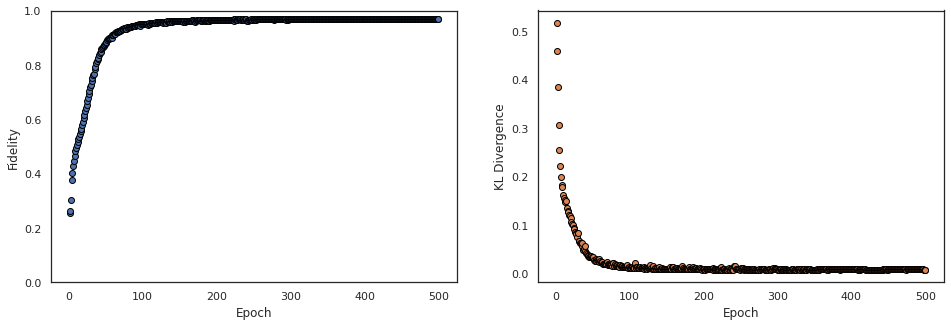

In [98]:
fidelities = callbacks[0]["Fidelity"]
KLs = callbacks[0]["KL_Divergence"]
epoch_range = np.arange(period, epoch + 1, period)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
ax = axs[0]
ax.plot(epoch_range, fidelities, "o", color = "C0", markeredgecolor = "black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")
ax.set_ylim(0.00, 1.00)

ax = axs[1]
ax.plot(epoch_range, KLs, "o", color = "C1", markeredgecolor = "black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

## save model & train log

In [99]:
# save model
nn_state_dm.save("./exp003/model.pt")
# save train log
train_log_df = pd.DataFrame()
train_log_df["epoch"] = np.arange(period, epoch+1, period)
train_log_df["Fidelity"] = callbacks[0]["Fidelity"]
train_log_df["KL_Divergence"] = callbacks[0]["KL_Divergence"]
train_log_df["Observable_XX_ev"] = callbacks[0]["Observable_XX_ev"]
train_log_df["Observable_XZ_ev"] = callbacks[0]["Observable_XZ_ev"]
train_log_df.to_csv("./exp003/train_log.csv", index=False)